# Import relevant libraries

In [1]:
import numpy as np
from sympy import Matrix, latex

# A bunch of stuff from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit import transpile
from qiskit_aer import Aer
from qiskit import QuantumCircuit
from qiskit.circuit import Instruction
from qiskit.transpiler.passes import Optimize1qGatesDecomposition
from qiskit.transpiler import PassManager
from qiskit.quantum_info import Operator

# Define process fidelity

In [2]:
def process_fidelity(U, V):
    d = U.shape[0]
    overlap = np.trace(np.conj(U.T) @ V) / d
    return np.abs(overlap)**2

# Get the QFT8 circuit

Create and draw standard QFT circuit (comprising H and CPHASE gates)

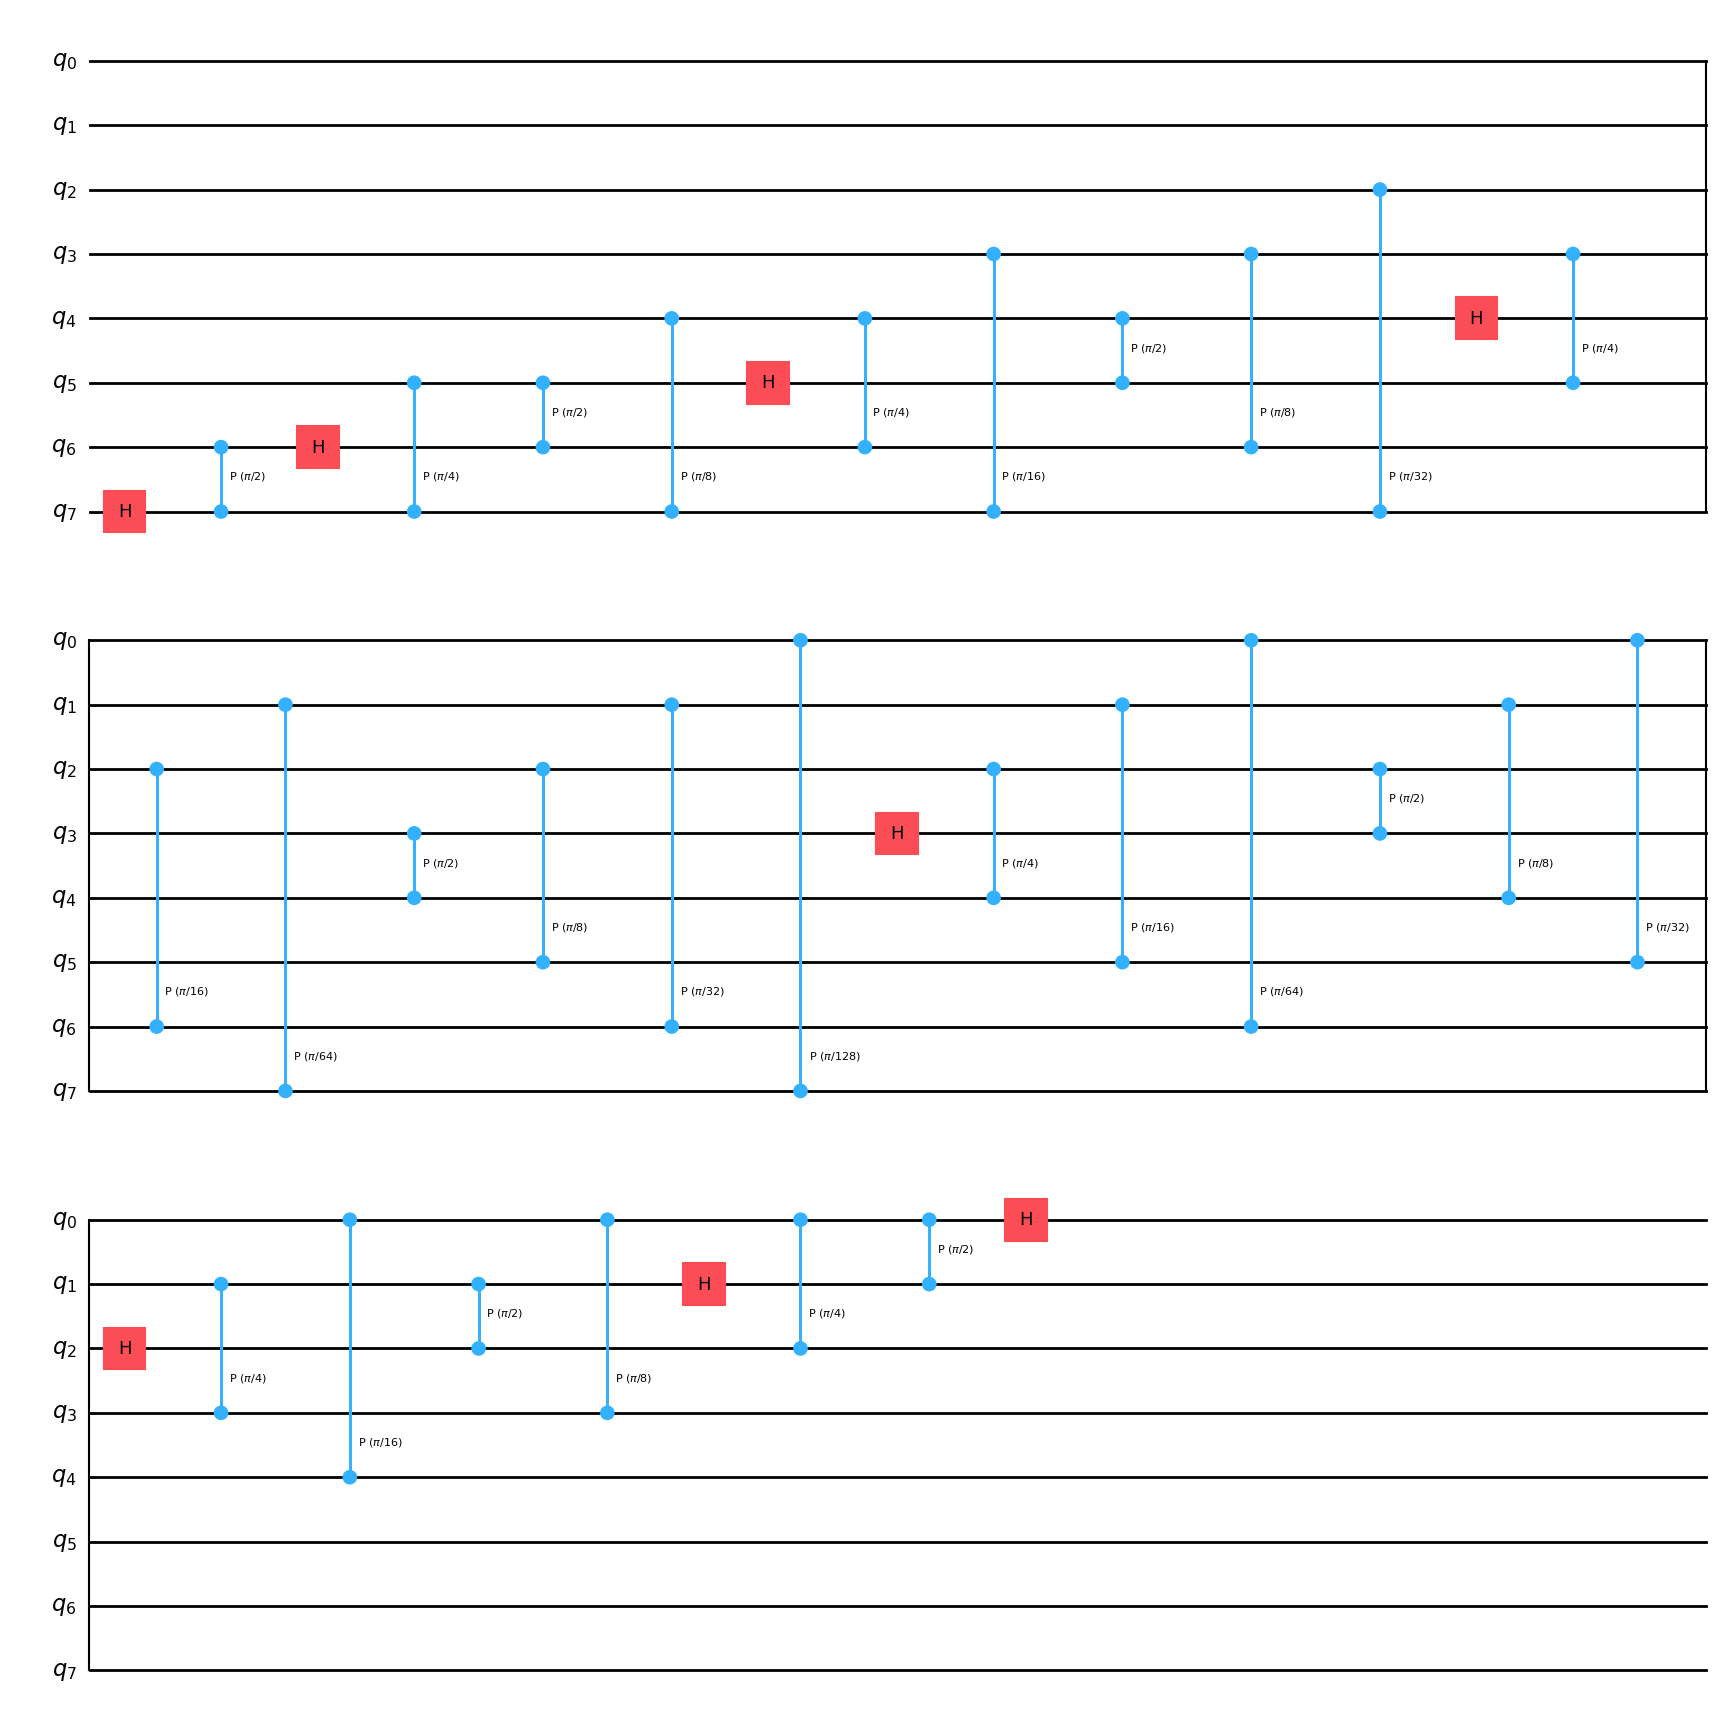

In [3]:
num_qubits = 8

# Create a 8-qubit QFT circuit
qft = QFT(num_qubits, do_swaps=False).decompose()

# To draw it
qft.draw("mpl")

In [4]:
# Get the unitary matrix (as NumPy array)
# U = np.sqrt(2**num_qubits)*Operator(qft).data
U = Operator(qft).data

# Round to clean up float values
U_ideal = np.round(U, 7)

# print(U_rounded)

# print(U_rounded[:, 0])
# print(U_rounded[17, :])
# print(len(U_rounded[:, 0]))

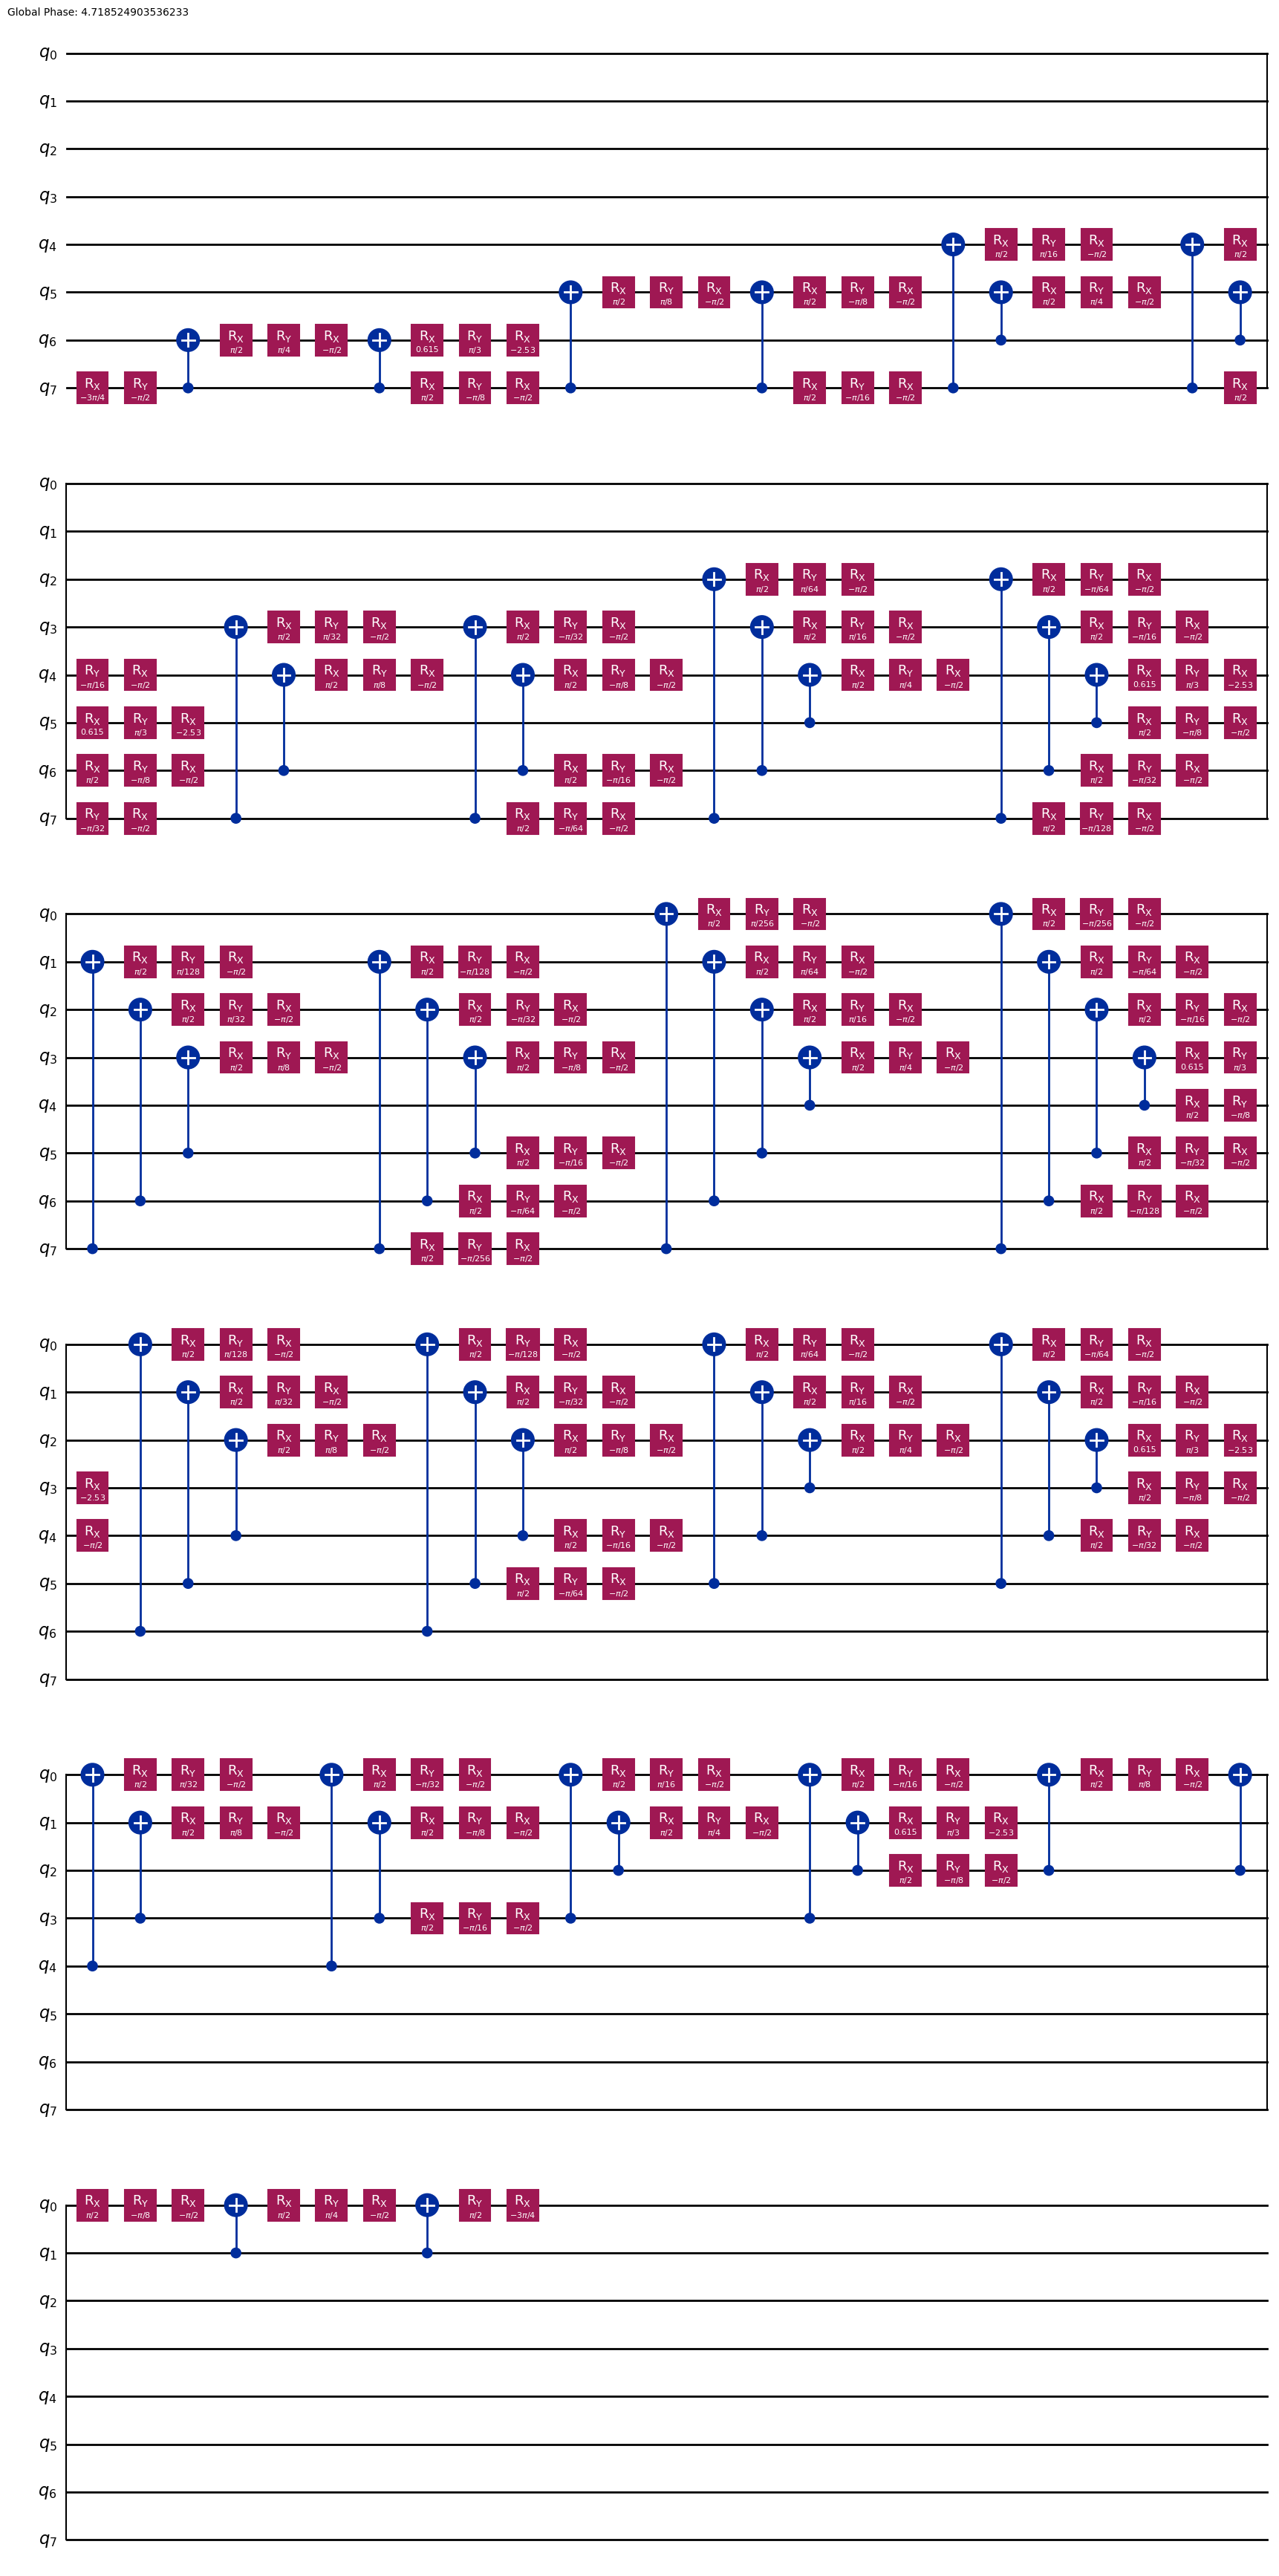

In [5]:
# Transpile QFT circuit to only use RX, RY, and CNOT
compiled_qft = transpile(qft, basis_gates=["rx", "ry", "cx"])

# compiled_qft.cx(0,7)
# compiled_qft.cx(7,0)
# compiled_qft.cx(0,7)

# compiled_qft.cx(1,6)
# compiled_qft.cx(6,1)
# compiled_qft.cx(1,6)

# compiled_qft.cx(2,5)
# compiled_qft.cx(5,2)
# compiled_qft.cx(2,5)

# compiled_qft.cx(3,4)
# compiled_qft.cx(4,3)
# compiled_qft.cx(3,4)

compiled_qft.draw("mpl")

In [6]:
# compiled_qft.h(0)

# Get the unitary matrix (as NumPy array)
# U = np.sqrt(2**num_qubits)*Operator(compiled_qft).data
U = Operator(compiled_qft).data

# Round to clean up float values
U_rounded = np.round(U, 7)

print(process_fidelity(U_ideal, U_rounded))

# print(U_rounded[:, 0])
# print(U_rounded[17, :])
# print(U_rounded[:, 0])
# print(len(U_rounded[:, 0]))

1.0000003820642762


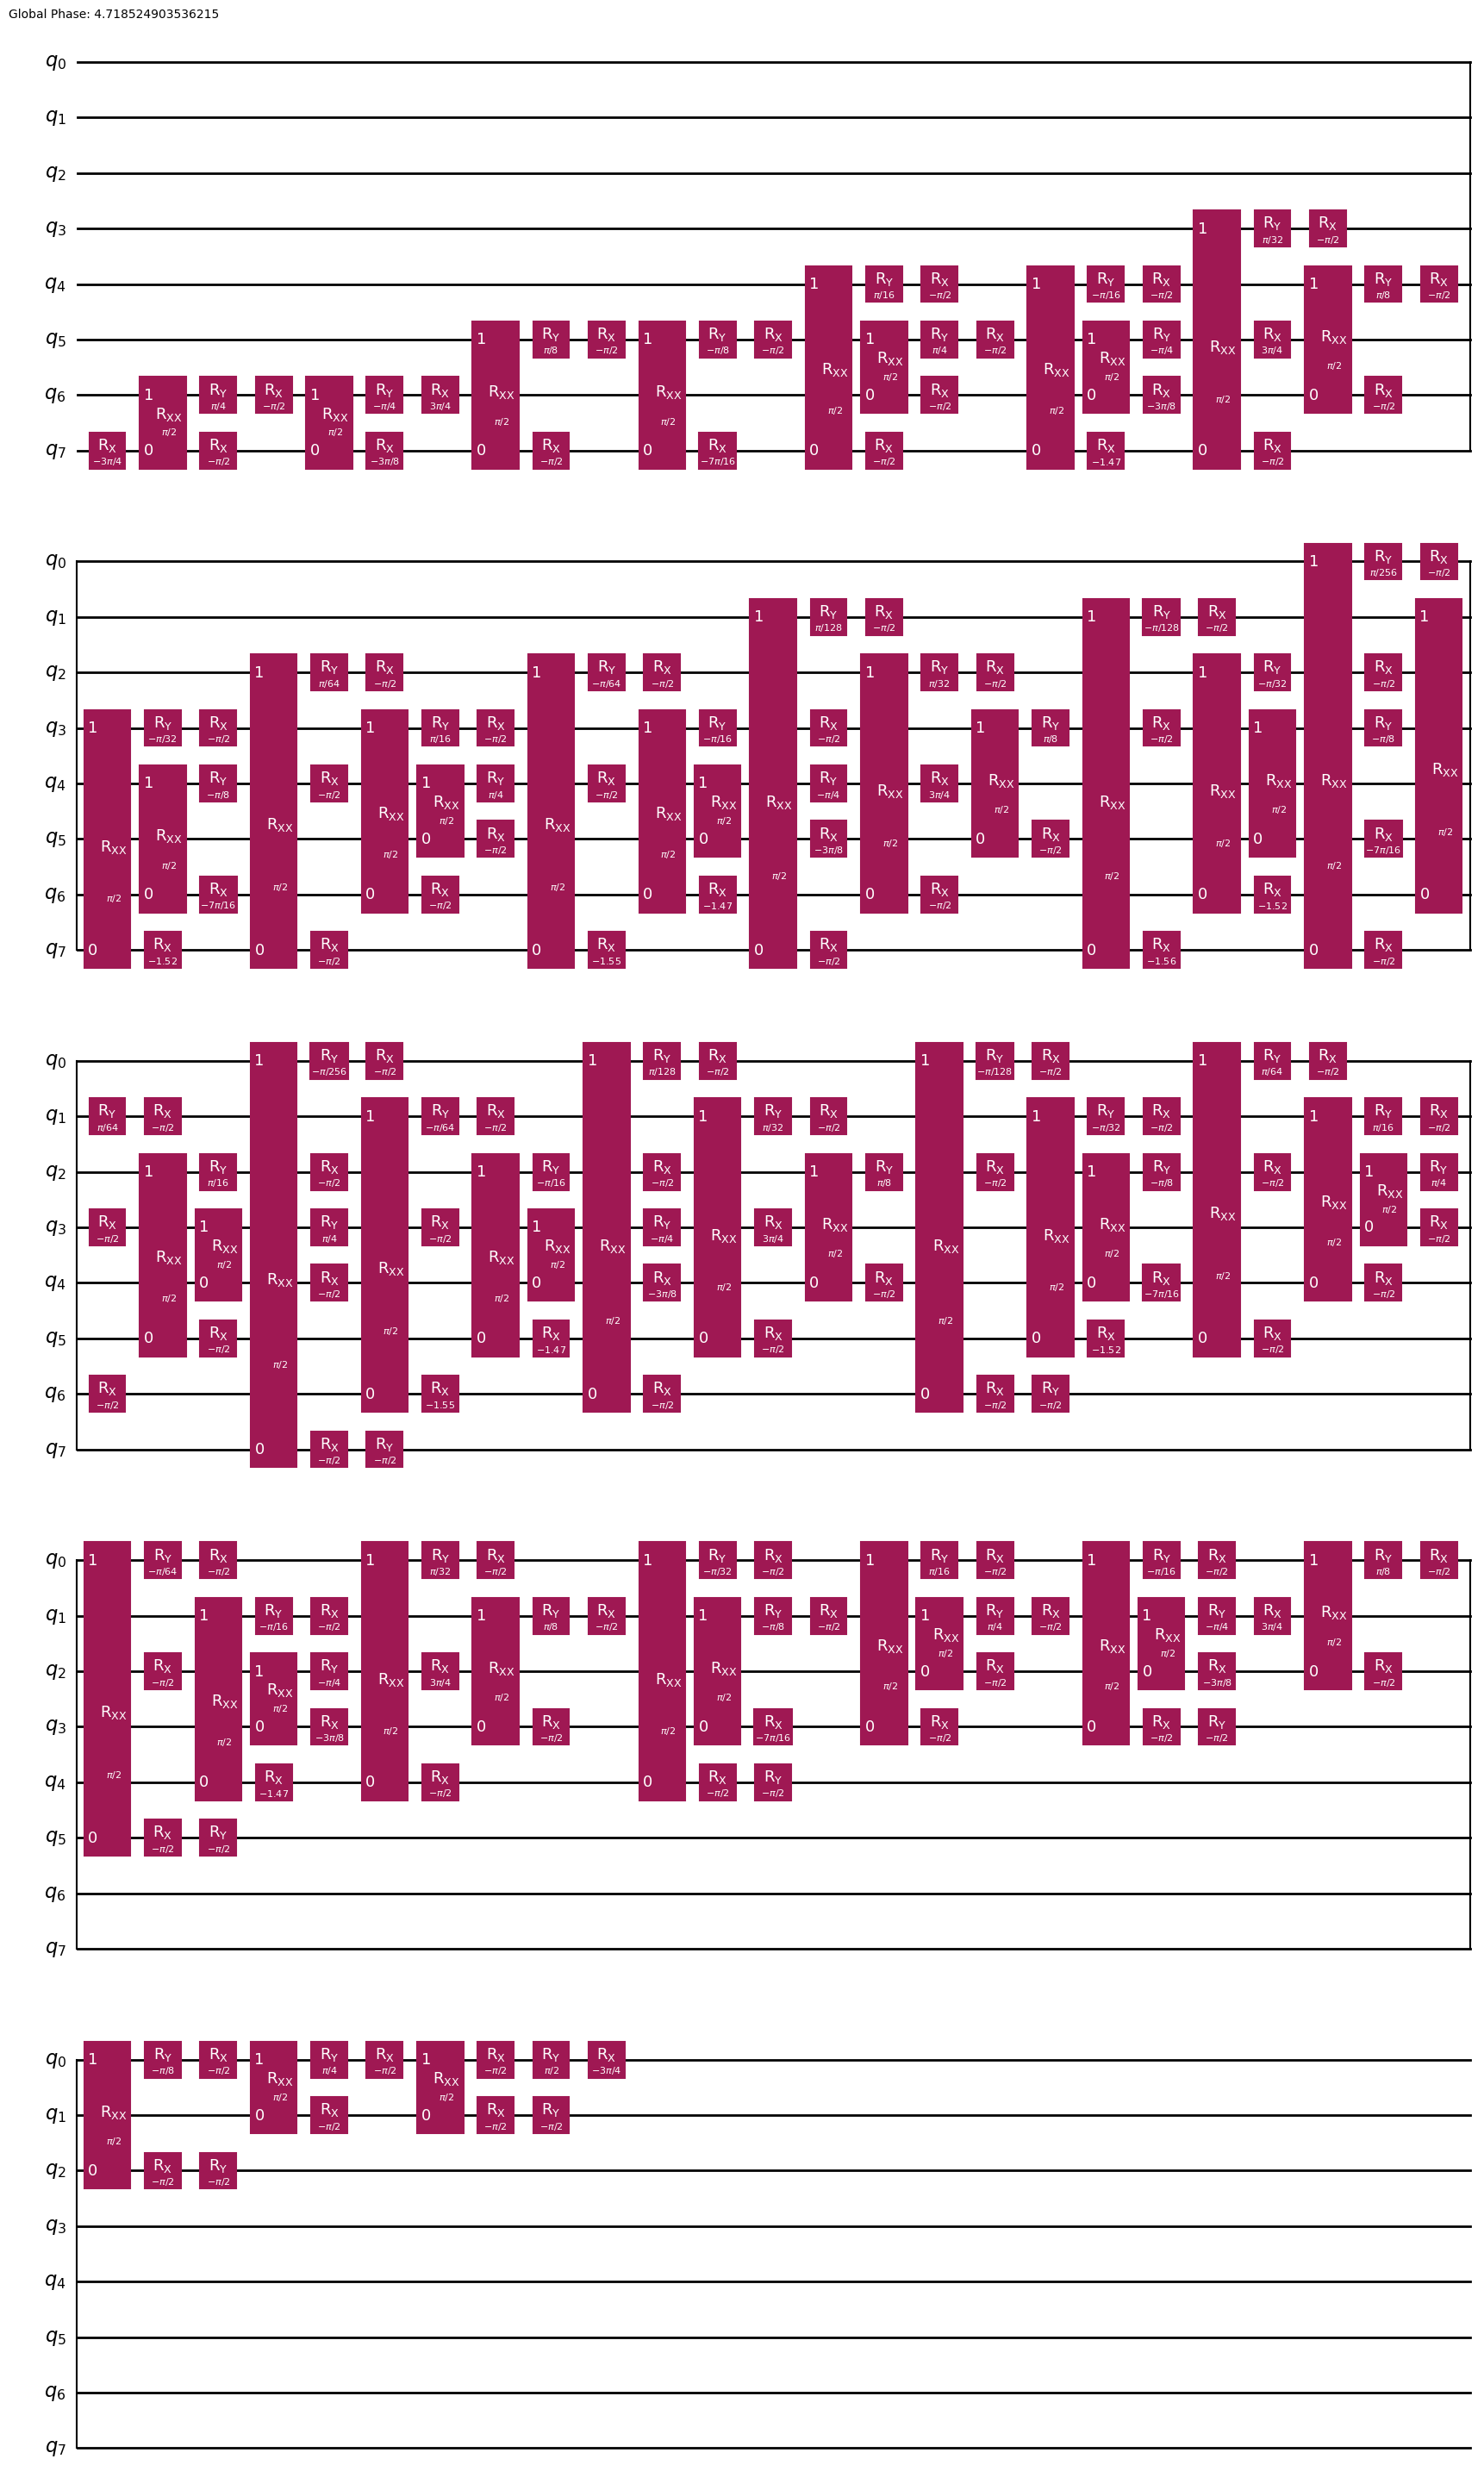

In [7]:
# Transpile QFT circuit to only use arbitrary 2 qubit rotations and RXX (with arbitrary angles)

compiled_qft_rxx = transpile(compiled_qft, basis_gates=["rx", "ry", "rxx"])

compiled_qft_rxx.draw("mpl")

In [8]:
# Get the unitary matrix (as NumPy array)
# U = np.sqrt(2**num_qubits)*Operator(compiled_qft_rxx).data

# compiled_qft_rxx.cx(0,7)
# compiled_qft.h(0)

U = Operator(compiled_qft_rxx).data

# Round to clean up float values
U_rounded = np.round(U, 7)

print(process_fidelity(U_ideal, U_rounded))
# print(U_rounded[:, 0])
# print(len(U_rounded[:, 0]))

1.0000003820642762


## Try fixed angle rxx

Replace CNOTs with the MS gate

In [17]:
# define function to replace CNOT with MS gate

def replace_cnot_with_MSgate(circuit):

    new_circuit = QuantumCircuit(circuit.num_qubits)

    for instr, qargs, cargs in circuit.data:
        qubit_indices = [circuit.qubits.index(q) for q in qargs]
        if instr.name == 'cx':
            # tgt, ctrl = qubit_indices
            ctrl, tgt = qubit_indices
            # Custom replacement for CNOT
            new_circuit.ry(np.pi/2, ctrl)
            new_circuit.rxx(np.pi/2, tgt, ctrl)
            # new_circuit.rxx(np.pi/2, ctrl, tgt)
            new_circuit.rx(-np.pi/2, tgt)
            new_circuit.rx(-np.pi/2, ctrl)
            new_circuit.ry(-np.pi/2, ctrl)
        
        else:
            new_circuit.append(instr, qubit_indices, cargs)

    return new_circuit

/var/folders/k3/sslkvfs91_53v_sx11v7hzbw0000gn/T/ipykernel_32101/791243583.py:7: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


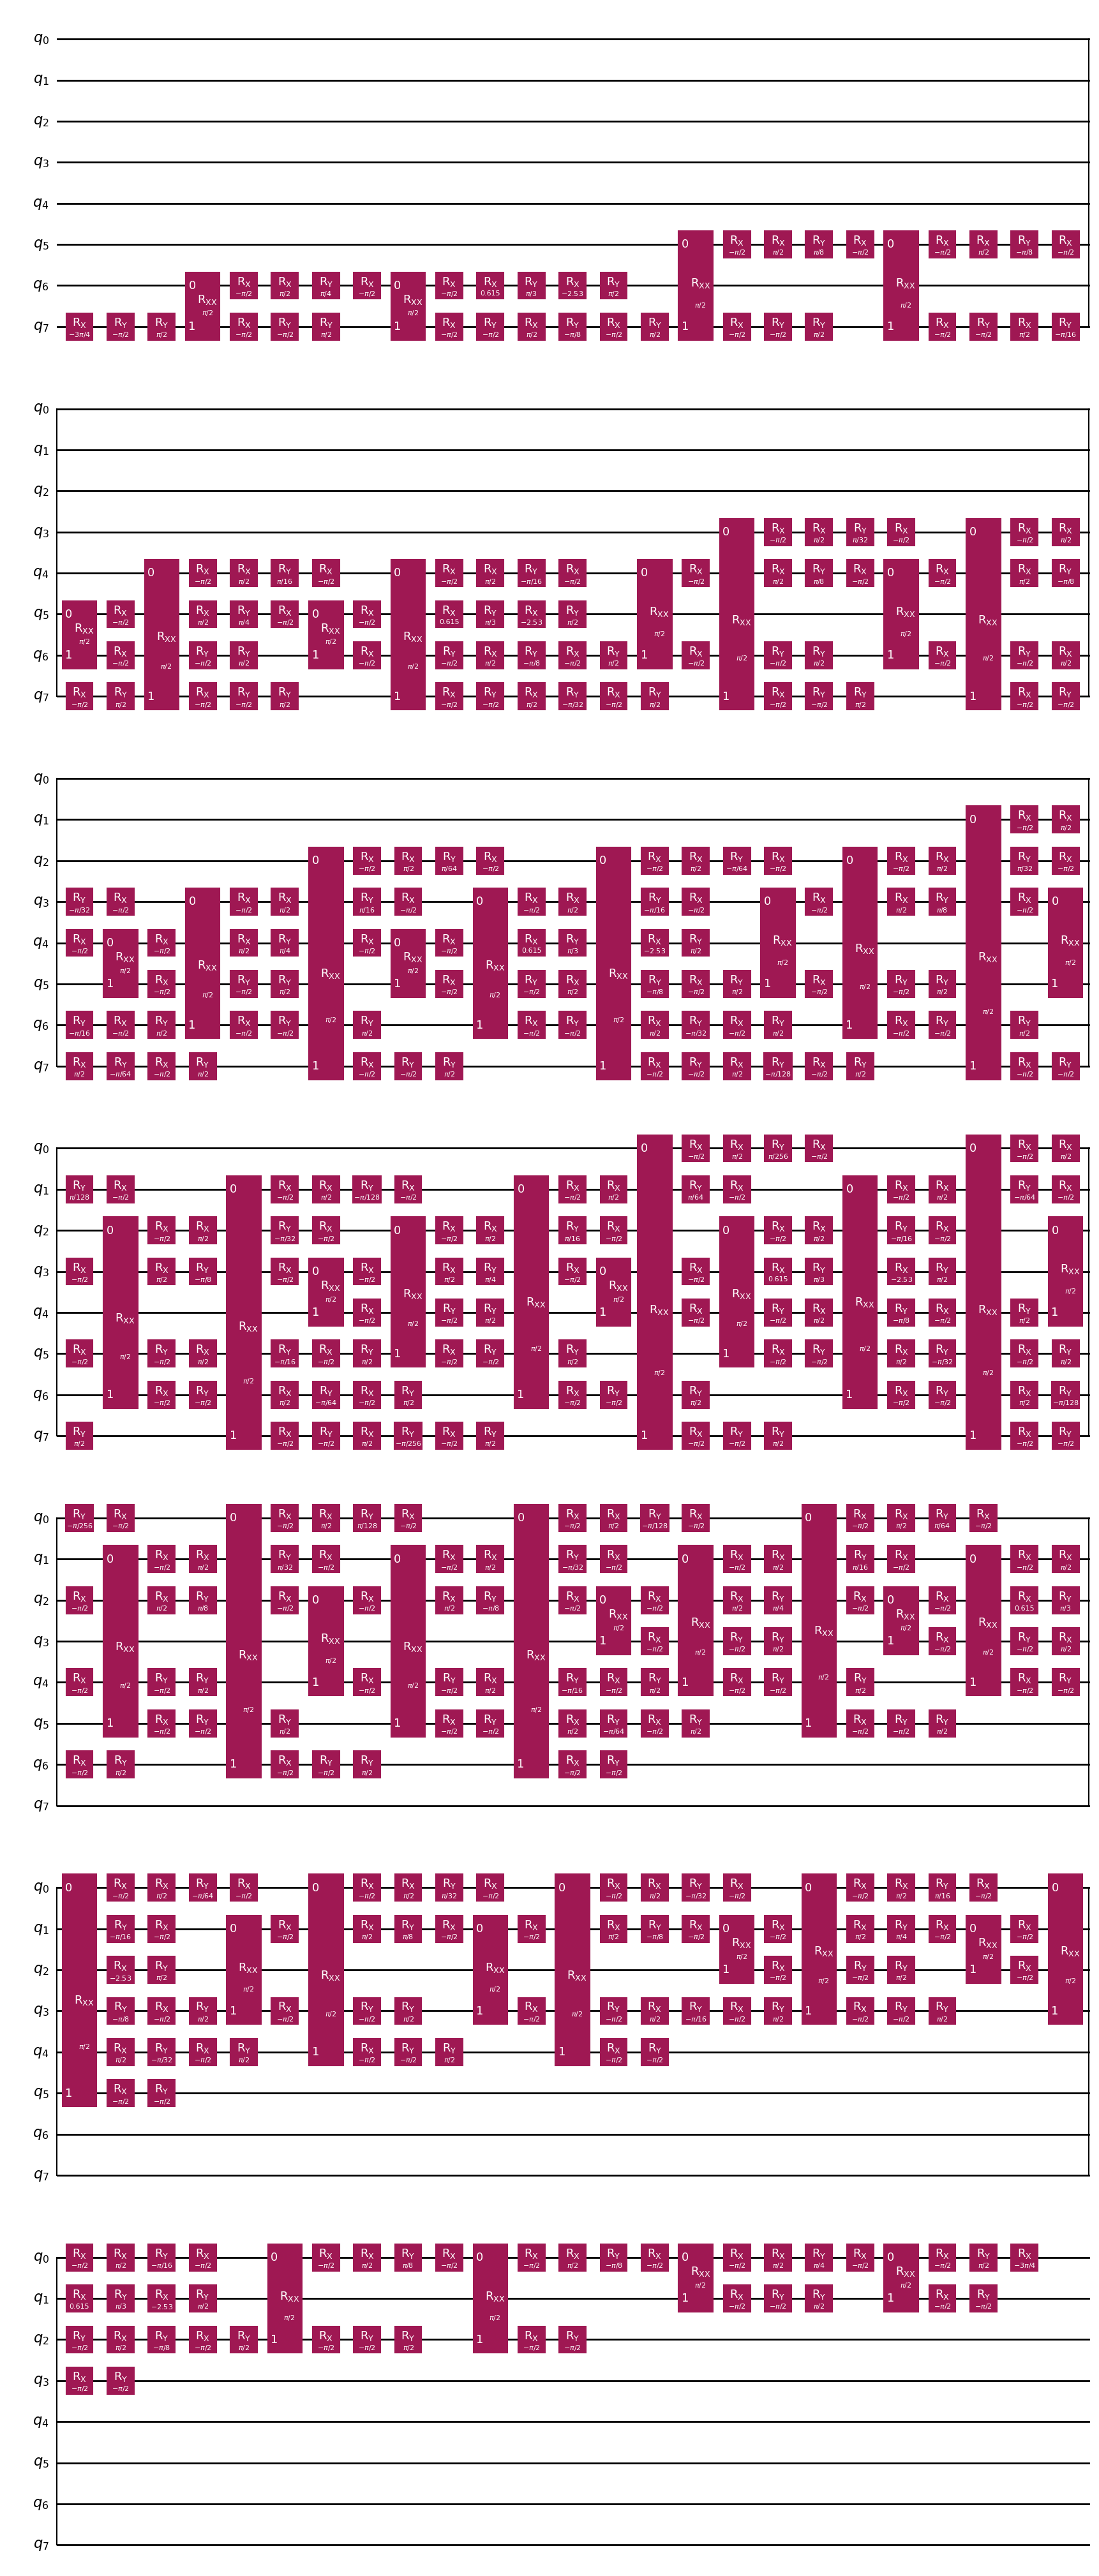

In [18]:
compiled_qft_MSgate = replace_cnot_with_MSgate(compiled_qft)
compiled_qft_MSgate.draw("mpl")

In [19]:
# compiled_qft_MSgate.h(0)

# Get the unitary matrix (as NumPy array)
U = Operator(compiled_qft_MSgate).data

# Round to clean up float values
U_rounded = np.round(U, 7)

print(process_fidelity(U_ideal, U_rounded))

1.0000000405058769


Simplify single qubit rotations

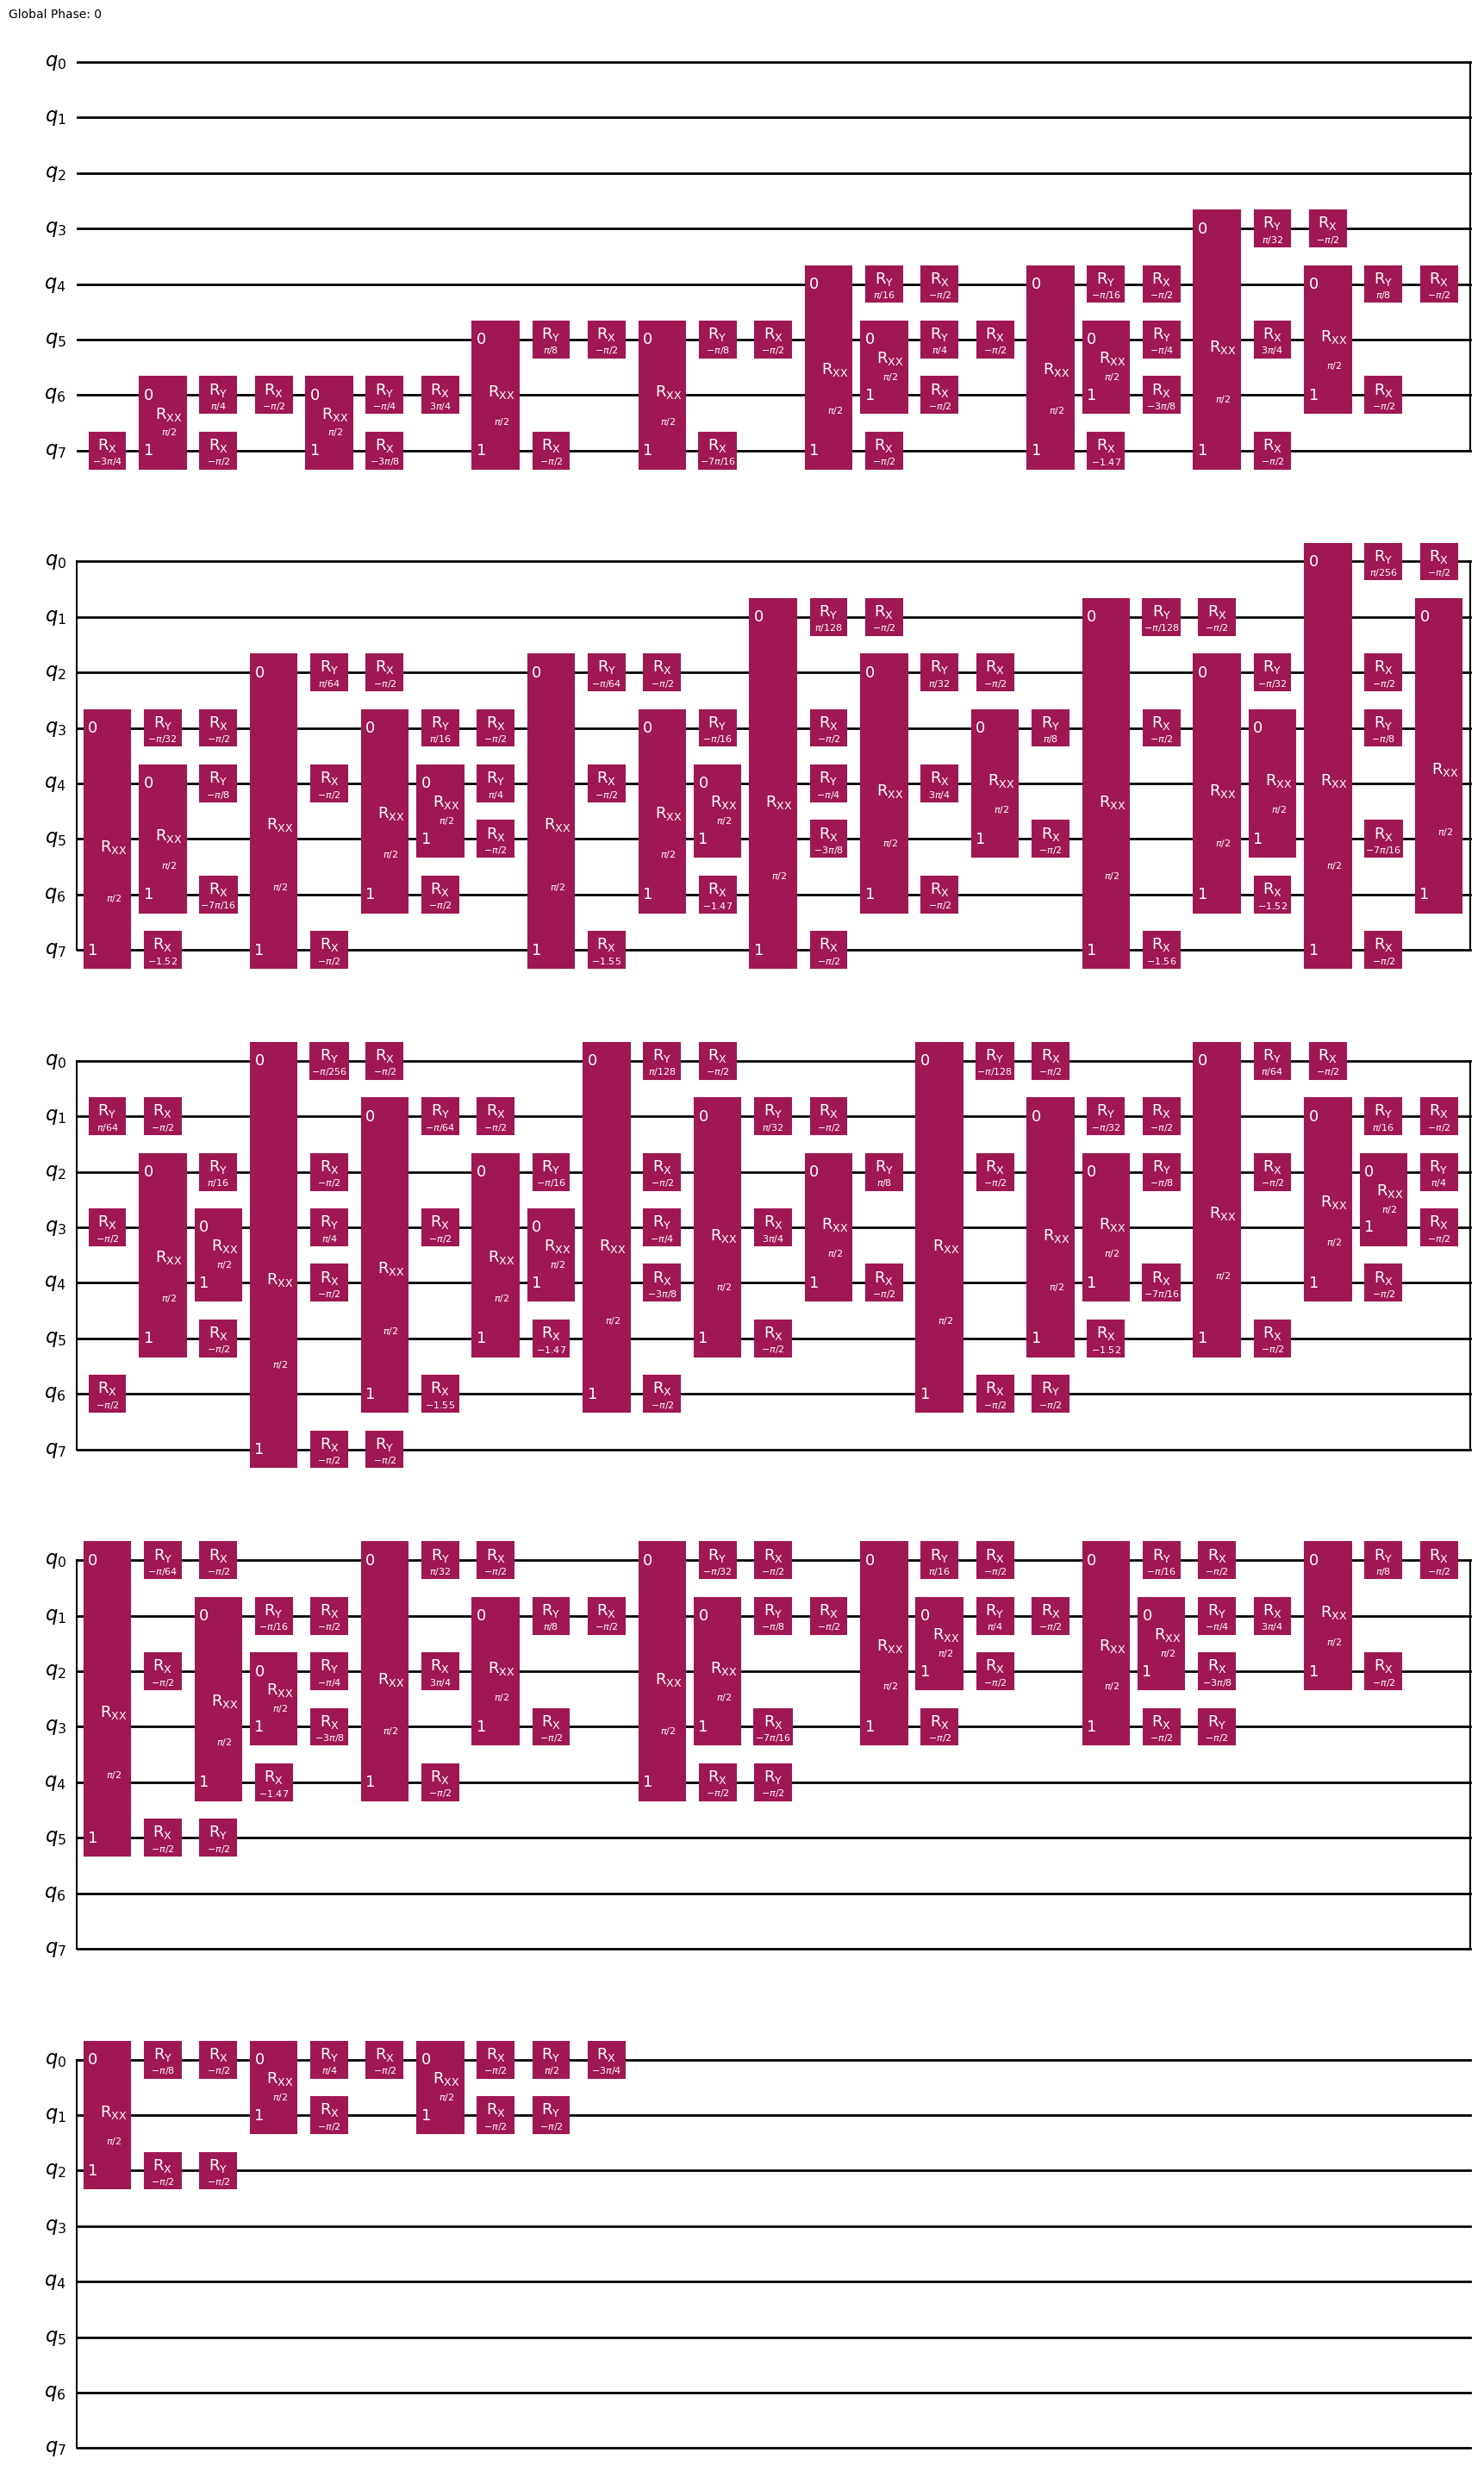

In [20]:
pass_manager = PassManager(Optimize1qGatesDecomposition(basis=['rx', 'ry']))
simplified = pass_manager.run(compiled_qft_MSgate)

simplified.draw("mpl")

In [21]:
# Get the unitary matrix (as NumPy array)
U_new = Operator(simplified).data

# Round to clean up float values
U_rounded = np.round(U_new, 7)

print(process_fidelity(U_ideal, U_rounded))

1.0000000405058769


# Export the gates in the relevant format

Gate list will be a vector of vectors, each one following the following notation:

An entry represents a list of gates to do in a given time step, defined as
[Ua,Ub,...]
Where U_i is the gate to apply in the time step. A complete list might look like
[
    [Ua,Ub,Uc],
    [Ud],
    [Ue,Uf],
    ...
]

The possible gates U_i are
 - ("RX", angle, ion_index)
 - ("RY", angle, ion_index)
 - ("MS", pi/4, (control_index, target_index))

In [28]:
from qiskit.converters import circuit_to_dag

In [41]:
# dag = circuit_to_dag(simplified)
# dag = circuit_to_dag(compiled_qft)
dag = circuit_to_dag(compiled_qft_rxx)

for i, layer in enumerate(dag.layers()):
    print(f"Time step {i}: {[op for op in layer['graph'].op_nodes()]}")

Time step 0: [DAGOpNode(op=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[-2.356194490192344]), qargs=(Qubit(QuantumRegister(8, 'q'), 7),), cargs=())]
Time step 1: [DAGOpNode(op=Instruction(name='rxx', num_qubits=2, num_clbits=0, params=[1.5707963267948966]), qargs=(Qubit(QuantumRegister(8, 'q'), 7), Qubit(QuantumRegister(8, 'q'), 6)), cargs=())]
Time step 2: [DAGOpNode(op=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[0.7853981633974483]), qargs=(Qubit(QuantumRegister(8, 'q'), 6),), cargs=()), DAGOpNode(op=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[-1.5707963267948966]), qargs=(Qubit(QuantumRegister(8, 'q'), 7),), cargs=())]
Time step 3: [DAGOpNode(op=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[-1.5707963267948966]), qargs=(Qubit(QuantumRegister(8, 'q'), 6),), cargs=())]
Time step 4: [DAGOpNode(op=Instruction(name='rxx', num_qubits=2, num_clbits=0, params=[1.5707963267948966]), qargs=(Qubit(QuantumRegister(8, 'q'), 7), Qubit(Quant

In [42]:
time_steps = []

for i, layer in enumerate(dag.layers()):

    operations = []

    for op in layer['graph'].op_nodes():
        if op.name == 'rx':
            operations.append(('RX', op.params[0], op.qargs[0]._index))
        elif op.name == 'ry':
            operations.append(('RY', op.params[0], op.qargs[0]._index))
        elif op.name == 'rxx':
            operations.append(('MS', op.params[0], (op.qargs[0]._index, op.qargs[1]._index)))
        else:
            raise ValueError(f"Unsupported operation: {op.name}")
        
    time_steps.append(operations)
        
print(time_steps[0:5])

[[('RX', -2.356194490192344, 7)], [('MS', 1.5707963267948966, (7, 6))], [('RY', 0.7853981633974483, 6), ('RX', -1.5707963267948966, 7)], [('RX', -1.5707963267948966, 6)], [('MS', 1.5707963267948966, (7, 6))]]


Export to file

In [42]:
with open("time_steps_raw_fixedphi.txt", "w") as file:
    for step in time_steps:
        file.write(f"{step}\n")

# Try importing solution to pennylane

In [25]:
import pennylane as qml

# my_circuit = qml.from_qiskit(compiled_qft_rxx)
my_circuit = qml.from_qiskit(simplified)

In [26]:
import pennylane as qml
from pennylane import numpy as np

n = 8
dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def U_builtin():
    qml.QFT(wires=range(n))
    return qml.state()

@qml.qnode(dev)
def U_custom():
    my_circuit()
    return qml.state()

# Execute
state_c = U_custom()
state_b = U_builtin()

fidelity = abs(np.vdot(state_c, state_b))**2
print(f"State fidelity vs. built-in QFT: {fidelity:.8f}")

State fidelity vs. built-in QFT: 1.00000000


In [27]:
@qml.qnode(dev)
def circuit():
    qml.QFT(wires=range(8))
    return qml.density_matrix(wires=range(8))

@qml.qnode(dev)
def circuit_custom():
    my_circuit()
    return qml.density_matrix(wires=range(8))

expected_result = circuit()
user_result = circuit_custom()
user_fidelity = qml.math.fidelity(expected_result, user_result)
print("Fidelity of the circuit:", user_fidelity)

Fidelity of the circuit: 1.0000011065906593


## Create circuit from gate list

In [33]:
# Function to convert the gates schedule to a Pennylane circuit

def compiled_circuit(gates_schedule) -> qml.QNode:
    """
    Build the compiled circuit from the gates schedule.

    Args:
        gates_schedule (list): A list of gates where each gate is represented as a tuple.

    Returns:
        qml.QNode: A Pennylane QNode representing the circuit.
    """

    @qml.qnode(device=dev)
    def circuit():
        for step in gates_schedule:
            for gate in step:
                if gate[0] == "RX":
                    qml.RX(gate[1], wires=gate[2])
                elif gate[0] == "RY":
                    qml.RY(gate[1], wires=gate[2])
                elif gate[0] == "MS":
                    qml.IsingXX(gate[1], wires=gate[2])
        return qml.density_matrix(wires=range(8))

    return circuit

In [43]:
user_result = compiled_circuit(time_steps)()
user_fidelity = qml.math.fidelity(expected_result, user_result)
print("Fidelity of the circuit:", user_fidelity)

Fidelity of the circuit: 1.0000011602941257


Solution with blanks

In [48]:
# with open("circuit_output.txt", "r") as file:
# with open("time_steps_raw.txt", "r") as file:
with open("time_steps_raw_fixedphi.txt", "r") as file:
    time_steps_list = [eval(line.strip()) for line in file.readlines()]

print(time_steps_list[0:10])

[[('RY', 1.5707963267948966, 6), ('RX', 0.6154797086703869, 7)], [('RX', 1.5707963267948966, 6), ('RY', 1.570796326794897, 7)], [('RX', -1.5707963267948966, 7)], [('MS', 1.5707963267948966, (7, 6))], [('RY', 3.1415926535897927, 6), ('RX', -1.5707963267948966, 7)], [('RY', 0.7853981633974495, 7)], [('MS', 1.5707963267948966, (7, 6))], [('RX', 0.7853981633974492, 6), ('RY', 1.5707963267948963, 7)], [('RY', 1.5707963267948963, 6), ('RX', 0.562617536425785, 7)], [('RX', -2.356194490192345, 6), ('MS', 1.5707963267948966, (5, 7))]]


In [49]:
user_result = compiled_circuit(time_steps_list)()
user_fidelity = qml.math.fidelity(expected_result, user_result)
print("Fidelity of the circuit:", user_fidelity)

Fidelity of the circuit: 1.00000119021576


In [ ]:
filtered_time_steps_list = [step for step in time_steps_list if step]
print(filtered_time_steps_list[0:10])  # Print the first 10 elements to verify

[[('RY', -1.570796326794853, 0), ('RY', 1.5707963267948657, 1), ('RY', 1.5707963267949037, 2), ('RY', 1.570796326794899, 3), ('RY', 1.5707963267949037, 4), ('RY', -1.570796326794899, 5), ('RY', -1.5707963267948974, 6), ('RX', -0.8925477115664915, 7)], [('RX', -1.5707963267948974, 0), ('RX', 1.5707963267948957, 1), ('RX', 1.5707963267948957, 2), ('RX', 1.5707963267948957, 3), ('RX', 1.5707963267948957, 4), ('RX', -1.5707963267948974, 5), ('RX', -1.5707963267948974, 6), ('RY', 3.141592653589793, 7)], [('MS', -0.7853981633974492, (6, 7))], [('RX', 0.7853981633974492, 6), ('RX', 0.11150097983152474, 7)], [('MS', -0.3926990816987228, (5, 7))], [('RY', 1.5707963267948963, 6)], [('RX', -2.0007915934239975, 6), ('RX', -0.3926990816987228, 5), ('RX', -0.279579778925501, 7)], [('RY', 3.141592653589791, 5), ('RY', 3.141592653589792, 7)], [('MS', -0.7853981633974492, (5, 6))], [('RX', 2.3561944901923457, 5), ('RX', 0.7376473226926734, 6), ('RX', 0.1963495408493614, 4), ('RX', 0.6010456949634833, 7

In [40]:
user_result = compiled_circuit(filtered_time_steps_list)()
user_fidelity = qml.math.fidelity(expected_result, user_result)
print("Fidelity of the circuit:", user_fidelity)

Fidelity of the circuit: 0.9521173678048876


# Test reading from file

In [ ]:
with open("time_steps_raw.txt", "r") as file:
    time_steps_list = [eval(line.strip()) for line in file.readlines()]

In [ ]:
print(time_steps_list[0:5])

# Check CNOT decomposition

In [44]:
# define function to replace CNOT with MS gate

def replace_cnot_with_MSgate(circuit):

    new_circuit = QuantumCircuit(circuit.num_qubits)

    for instr, qargs, cargs in circuit.data:
        qubit_indices = [circuit.qubits.index(q) for q in qargs]
        if instr.name == 'cx':
            # tgt, ctrl = qubit_indices
            ctrl, tgt = qubit_indices
            # Custom replacement for CNOT
            new_circuit.ry(np.pi/2, ctrl)
            new_circuit.rxx(np.pi/2, tgt, ctrl)
            # new_circuit.rxx(np.pi/2, ctrl, tgt)
            new_circuit.rx(-np.pi/2, tgt)
            new_circuit.rx(-np.pi/2, ctrl)
            new_circuit.ry(-np.pi/2, ctrl)

            # new_circuit.p(-np.pi/4, ctrl)
            new_circuit.p(-np.pi/4, tgt)
        
        else:
            new_circuit.append(instr, qubit_indices, cargs)

    return new_circuit

Check that CNOT decomposition into the MS gate does what it's supposed to

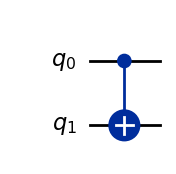

In [41]:
# Create quantum circuit with single CNOT

qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.draw("mpl")

/var/folders/k3/sslkvfs91_53v_sx11v7hzbw0000gn/T/ipykernel_27533/3404104121.py:7: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


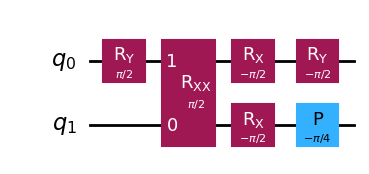

In [45]:
# Create corresponding circuit with MS gate

qc_new = replace_cnot_with_MSgate(qc)
qc_new.draw("mpl")

In [38]:
# Get the unitary matrix (as NumPy array)
U = Operator(qc).data

# Round to clean up float values
U_rounded = np.round(U, 3)

print(U_rounded)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


In [46]:
# Get the unitary matrix (as NumPy array)
U = Operator(qc_new).data

# Round to clean up float values
U_rounded = np.round(U, 3)

print(U_rounded)

[[ 0.707+0.707j  0.   +0.j     0.   +0.j    -0.   -0.j   ]
 [ 0.   +0.j     0.   -0.j    -0.   -0.j     0.707+0.707j]
 [ 0.   +0.j    -0.   -0.j     1.   +0.j     0.   +0.j   ]
 [-0.   -0.j     1.   +0.j     0.   +0.j     0.   -0.j   ]]
